# Contact Info:

- Ryan Kuhl
- Email: ryan@kuhl.dev
- Linkedin: https://www.linkedin.com/in/kuhl/

# First Thing First: Happy "The Fast and the Furious 9" Release Day!

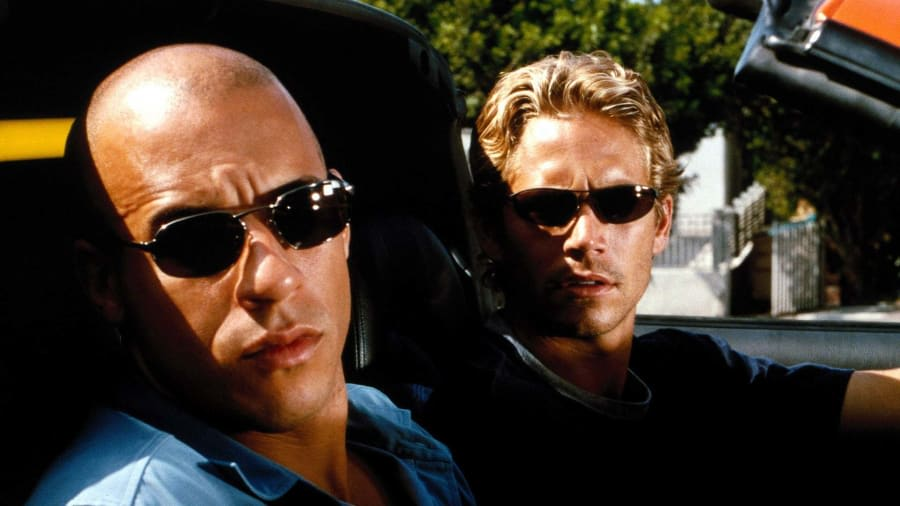

* Disclaimer: I live my life a quarter mile at a time ¯\\_(ツ)_/¯

# Setting Up SQLAlchemy Locally, any You!

### Code to make the DB

The following is specific to `Postgresql`, though other DBMS' like `MySQL` should look very similar.

```sql

-- Easy one first; no relationships
-- Note the auto-indexing id field, 
--   we don't want to have to fuss with setting those on write
--   so the DBMS will do that for us!
CREATE TABLE cuisines (
    id SERIAL PRIMARY KEY,
    name TEXT NOT NULL -- Fields can be set as NOT NULL optionally, or nullable by omitting that
);

CREATE TABLE restaurants (
    id SERIAL PRIMARY KEY,
    name TEXT NOT NULL,
    address TEXT NOT NULL,
    phone_number TEXT NOT NULL,
    price_range_lower INT, -- Note the nullable field
    price_range_upper INT,
    rating DECIMAL, -- Decimal types are good to use for decimal precision numbers to aviod floating point rounding errors
    -- Note that defaults can be added here! You can omit these from 
    -- the python instantiation and they'll still have values on write
    review_count INT NOT NULL DEFAULT 0, 
    excellent_count INT NOT NULL DEFAULT 0,
    very_good_count INT NOT NULL DEFAULT 0,
    average_count INT NOT NULL DEFAULT  0,
    poor_count INT NOT NULL DEFAULT  0,
    terrible_count INT NOT NULL DEFAULT  0
);

-- This is funky: a Many:Many relationship. Take care to note how this is used in SQLAlchemy below
CREATE TABLE restaurants_cuisines_map (
    id SERIAL PRIMARY KEY ,
    restaurant_id INT NOT NULL REFERENCES restaurants(id),  -- First time we've seen a "REFERENCES", that means it's a foreign key
    cuisine_id INT NOT NULL REFERENCES cuisines(id)
);


CREATE TABLE users (
    id SERIAL PRIMARY KEY,
    first_name TEXT,
    last_name TEXT
);

CREATE TABLE users_cuisines_map (
    id SERIAL PRIMARY KEY ,
    user_id INT NOT NULL REFERENCES users(id),
    cuisine_id INT NOT NULL REFERENCES cuisines(id)
);

CREATE TABLE reviews (
    id SERIAL PRIMARY KEY ,
    user_id INT NOT NULL REFERENCES users(id), -- Note the Many to One relationship: many reviews belong to one user
    restaurant_id INT NOT NULL REFERENCES restaurants(id), -- Similarly, many reviews are referencing one restaurant
    review TEXT,
    rating INT
);

```

In [1]:
from itertools import chain
from sqlalchemy import Table, Column, Integer, ForeignKey, create_engine, MetaData
from sqlalchemy.orm import declarative_base, Session, relationship
from decimal import Decimal

In [2]:
# You're going to want to use whatever connection you need, psycopg2 is for Python -> PostgreSQL
# and whatever database you're using. The format is postgresql+psycopg2://{username}:{password}@{url or localhost}:{port, 5432 by default}/{database}
# CREATE DATABASE {database name};
# \c {database name}
url = 'postgresql+psycopg2://ryankuhl@localhost:5432/lightning_talk'
debug = False

engine= create_engine(url, echo=debug)

In [3]:
# Let's test the connection to our database by running some raw SQL
with engine.connect() as connection:
    rows=connection.execute('SELECT * FROM restaurants')
    for idx, row in enumerate(rows):
        if idx >= 5:
            break
        print(row)

### Let's create the python models

In [4]:
# Boilerplate, no fun to be seen here
def _get_reflected_metadata(engine):
    metadata = MetaData(bind=engine)
    metadata.reflect(views=True)
    return metadata

meta = _get_reflected_metadata(engine)
tables = meta.tables

model_class_registry = {}
Model = declarative_base(
    metadata=meta, class_registry=model_class_registry, name='Model'
)

### SQLAlchemy Docs!

The [one and only place](https://docs.sqlalchemy.org/en/14/orm/basic_relationships.html) to go for remembering how the heck to set up that foreign key relationship
- [One to One](https://docs.sqlalchemy.org/en/14/orm/basic_relationships.html#one-to-one)
- [One to Many](https://docs.sqlalchemy.org/en/14/orm/basic_relationships.html#one-to-many)
- [Many to One](https://docs.sqlalchemy.org/en/14/orm/basic_relationships.html#many-to-one)
- [Many to Many](https://docs.sqlalchemy.org/en/14/orm/basic_relationships.html#many-to-many)

### Example One to Many Relationship

```python
class Parent(Base):
    __tablename__ = 'parent'
    id = Column(Integer, primary_key=True)
    children = relationship("Child", back_populates="parent")

class Child(Base):
    __tablename__ = 'child'
    id = Column(Integer, primary_key=True)
    parent_id = Column(Integer, ForeignKey('parent.id'))
    parent = relationship("Parent", back_populates="children")

```

In [5]:
class Cuisine(Model):
    # You'll notice that the class names and table names are different. 
    # It is common to make class names singular and table names plural!
    # Because of this, we need to tell SQLAlchemy what table we're 
    # referencing explicitly as follows:
    __table__ = tables['cuisines']
    
    id: int
    name: str
        
class Restaurant(Model):
    __table__ = tables['restaurants']
    
    id:int
    name: str
    address: str
    phone_number: str
    price_range_lower: int
    price_range_upper: int
    rating: Decimal
    review_count: int
    excellent_count: int
    very_good_count: int
    average_count: int
    poor_count: int
    terrible_count: int
    
    # Many to Many Relationship
    cuisines = relationship(
        'Cuisine',  # Class at the other side of the relationship
        secondary=tables['restaurants_cuisines_map'],  # Leverages a mapping table to store all restaurant/cuisine combos
        uselist=True,
    )
    
    # One to Many Relationship
    reviews = relationship(
        'Review',  # Class at the other side of the relationship
        uselist=True  # Because there's "many" on the other side, we store them in a list!
    )
    
class Review(Model):
    __table__ = tables['reviews']

    review: str
    rating: int
        
    user_id: int  # ID is only at the child side of the Many to One relationship, is that intuitive?
    user = relationship(
        'User',
        back_populates='reviews',  # In the User class, we'll append this to the reviews list. Note back_populates and backref are subtly different!
        foreign_keys='Review.user_id'  # Our foreign key to the Review class is user_id contained in the Review class
    )
    
    restaurant_id: int
    restaurant = relationship(
        'Restaurant',
        back_populates='reviews',
        foreign_keys='Review.restaurant_id'
    )

    
class User(Model):
    __table__ = tables['users']
    
    first_name: str
    last_name: str

    cuisines = relationship(
        'Cuisine',
        secondary=tables['users_cuisines_map'],
        uselist=True
    )
    
    reviews = relationship(
        'Review',
        back_populates='user',
        uselist=True,
    )

In [6]:
dir(Restaurant)

['__abstract__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__mapper__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__table__',
 '__weakref__',
 '_sa_class_manager',
 '_sa_registry',
 'address',
 'average_count',
 'cuisines',
 'excellent_count',
 'id',
 'metadata',
 'name',
 'phone_number',
 'poor_count',
 'price_range_lower',
 'price_range_upper',
 'rating',
 'registry',
 'review_count',
 'reviews',
 'terrible_count',
 'very_good_count']

In [7]:
with Session() as session:
    user_instance = User(first_name='Ryan', last_name='Kuhl')

    session.add(user_instance)
    session.commit()
    user_from_db = session.query(User).first()
    print(user_from_db.id)

1


In [8]:
with Session() as session:
    print(session.query(User).all())

[<__main__.User object at 0x7f84551d6b50>, <__main__.User object at 0x7f84551d6bd0>, <__main__.User object at 0x7f84551d6c50>]


In [9]:
import csv

# Using Kaggle dataset: https://www.kaggle.com/adrianmcmahon/mumbai-restaurants-trip-advisor-dataset, exported from .xls to .csv for the civilized.
with open('/Users/ryankuhl/Downloads/tripadvisor.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    rows = [row for row in reader]

In [10]:
rows[1:2]

[OrderedDict([('\ufeffname', '10th Street Cafe'),
              ('address',
               'Khar Pali Road, Road No 10, Khar Shop No 3 & 4, Mangal Bhavna, Mumbai 400049 India'),
              ('Phone', '+91 87790 92308'),
              ('price_range_from', ''),
              ('price_range_to', ''),
              ('cuisines', 'Italian, Cafe'),
              ('rating', '4.5'),
              ('review_count', '18'),
              ('excellent_count', ' 8'),
              ('very_good_count', '8'),
              ('average_count', '2'),
              ('poor_count', '0'),
              ('terrible_count', '0')])]

### Add all the cuisines

In [11]:
cuisines = set(x.strip().lower() for x in chain.from_iterable([row['cuisines'].split(',') for row in rows]) if x)
len(cuisines)

85

In [12]:
with Session() as session:
    print(session.query(Cuisine).count())

85


In [13]:
# Already added these
with Session() as session:
    session.add_all([Cuisine(name=cuisine) for cuisine in cuisines])
    session.commit()
    print(session.query(Cuisine).all()[0].__dict__)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x7f8455937710>, 'name': 'northern-italian', 'id': 1}


In [14]:
rows[0]

OrderedDict([('\ufeffname', '1 Tablespoon'),
             ('address',
              '23, Ram Villa, Opposite Sahkari Bhandar, Matunga East Opp Sahakari Bhandar, Matunga East,, Mumbai India'),
             ('Phone', '+91 22 2403 3441'),
             ('price_range_from', ''),
             ('price_range_to', ''),
             ('cuisines', 'Pizza, Fast food'),
             ('rating', '4.0'),
             ('review_count', '31'),
             ('excellent_count', ' 9'),
             ('very_good_count', '15'),
             ('average_count', '4'),
             ('poor_count', '2'),
             ('terrible_count', '1')])

In [20]:
restaurant_instances = []

for idx, row in enumerate(rows):
    cuisine_instances = []
    for cuisine in row['cuisines'].split(','):
        # Account for the empty str
        if not cuisine:
            continue
            
        cuisine_instance = session.query(Cuisine).filter_by(name=cuisine.strip().lower()).first()
        cuisine_instances.append(cuisine_instance)

    try:
        restaurant_instance = Restaurant(
            name=row['\ufeffname'], 
            address=row['address'], 
            phone_number=row['Phone'], 
            price_range_lower=int(row['price_range_from']) if row['price_range_from'] else None, 
            price_range_upper=int(row['price_range_to']) if row['price_range_to'] else None,
            cuisines=cuisine_instances,
            rating=Decimal(row['rating']),
            review_count=int(row['review_count']),
            excellent_count=int(row['excellent_count'].replace(',', '')),
            very_good_count=int(row['very_good_count'].replace(',', '')),
            average_count=int(row['average_count'].replace(',', '')),
            poor_count=int(row['poor_count'].replace(',', '')),
            terrible_count=int(row['terrible_count'].replace(',', '')),
        )
        restaurant_instances.append(restaurant_instance)
    except Exception as e:
        print(f'Malformed Row #{idx}')
        print(f'Row values: {row}')
        print(f'Error: {e}\n')
        

Malformed Row #2995
Row values: OrderedDict([('\ufeffname', ''), ('address', ''), ('Phone', ''), ('price_range_from', ''), ('price_range_to', ''), ('cuisines', ''), ('rating', ''), ('review_count', ''), ('excellent_count', ''), ('very_good_count', ''), ('average_count', ''), ('poor_count', ''), ('terrible_count', '')])
Error: [<class 'decimal.ConversionSyntax'>]

Malformed Row #2996
Row values: OrderedDict([('\ufeffname', ''), ('address', ''), ('Phone', ''), ('price_range_from', ''), ('price_range_to', ''), ('cuisines', ''), ('rating', ''), ('review_count', ''), ('excellent_count', ''), ('very_good_count', ''), ('average_count', ''), ('poor_count', ''), ('terrible_count', '')])
Error: [<class 'decimal.ConversionSyntax'>]

Malformed Row #2997
Row values: OrderedDict([('\ufeffname', ''), ('address', ''), ('Phone', ''), ('price_range_from', ''), ('price_range_to', ''), ('cuisines', ''), ('rating', ''), ('review_count', ''), ('excellent_count', ''), ('very_good_count', ''), ('average_count

In [21]:
restaurant_instances[0].__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f8456d3b110>,
 'name': '1 Tablespoon',
 'address': '23, Ram Villa, Opposite Sahkari Bhandar, Matunga East Opp Sahakari Bhandar, Matunga East,, Mumbai India',
 'phone_number': '+91 22 2403 3441',
 'price_range_lower': None,
 'price_range_upper': None,
 'cuisines': [<__main__.Cuisine at 0x7f845593b910>,
 'rating': Decimal('4.0'),
 'review_count': 31,
 'excellent_count': 9,
 'very_good_count': 15,
 'average_count': 4,
 'poor_count': 2,
 'terrible_count': 1}

In [22]:
with Session() as session:
    print(session.query(Restaurant).count())

0


In [31]:
# Check this out, you can pull a session off of an instance with Session.object_session! 
with Session.object_session(restaurant_instances[0].cuisines[0]) as session:
    session.add_all(restaurant_instances)
    session.commit()
    print(session.query(Restaurant).count())

2995


In [25]:
with Session() as session:
    restaurant_instance = session.query(Restaurant).first()
    user_instance = session.query(User).first()
    
    review = Review(
        review='foo-bar',
        rating=5,
        restaurant=restaurant_instance,
        user=user_instance
    )
    
    print(review.__dict__)
    session.add(review)
    session.commit()
    
    print(session.query(Review).count())

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x7f8457ee0e10>, 'review': 'foo-bar', 'rating': 5, 'restaurant': <__main__.Restaurant object at 0x7f8457f42b10>, 'user': <__main__.User object at 0x7f8457b61150>}
1


In [26]:
with Session() as session:
    user = session.query(User).first()
    cuisines = session.query(Cuisine).limit(10).all()
    
    user.cuisines = cuisines
    session.add(user)
    session.commit()
    
    print([c.name for c in user.cuisines]) 

['northern-italian', 'healthy', 'sports bars', 'vegetarian friendly', 'soups', 'gastropub', 'greek', 'jamaican', 'steakhouse', 'international']
